In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from tqdm import tqdm
import re
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_real = pd.read_csv('True.csv')
df_real.head(50)

In [ ]:
df_real.describe()

In [ ]:
df_real.subject.value_counts()

In [ ]:
df_real.isna().sum()

In [ ]:
df_real['date'] = df_real['date'].str.strip()

In [ ]:
df_real.text[0]

In [ ]:
df_fake = pd.read_csv('fake.csv')
df_fake.head(50)

### Standard Preprocessing

In [ ]:
import nltk
nltk.download('all')

In [55]:
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.tree import *

In [56]:
def chunking_process(txt):
  chunks = list(ne_chunk(pos_tag(word_tokenize(txt))))
  gpe_list = []
  person_list = []
  for i in chunks:
    if type(i)==Tree:
      person_list.append(i)
      if i.label() == "GPE":
        gpe_list.append(i.leaves())
      elif i.label() == "PERSON":
        person_list.append(i.leaves())       

  for j in gpe_list:
    if len(j)>1:
      gpe_str = "_".join([k for k, l in j])
      normal_str = " ".join([k for k, l in j])
      txt = re.sub(re.escape(normal_str), gpe_str, txt, count = 1)
  for j in person_list:
    person_str = " ".join([k for k, l in j])
    txt = re.sub(re.escape(person_str), " ", txt, count = 1)
    
  return txt

In [57]:
def decontraction(txt):
    txt = re.sub(r"can\'t", "can not", txt)
    txt = re.sub(r"won\'t", "will not", txt)
    txt = re.sub(r"n\'t", " not", txt)
    txt = re.sub(r"\'re", " are", txt)
    txt = re.sub(r"\'t", " not", txt)
    txt = re.sub(r"\'s", " is", txt)
    txt = re.sub(r"\'d", " would", txt)
    txt = re.sub(r"\'ll", " will", txt)
    txt = re.sub(r"\'m", " am", txt)
    txt = re.sub(r"\'ve", " have", txt)

    return txt

def to_lower(text):
    return text.lower()

def remove_whitespace(text):
    return  " ".join(text.split())

def only_alphabets(txt):
    txt = re.sub(r'[^a-z_]'," ",txt)
    return txt

In [58]:
def preprocess_text(text):
    text = chunking_process(text)
    text = to_lower(text)
    text = decontraction(text)
    if text[0].strip() == '(':
        text = " ".join(text.split("-")[1:])
    
    text = only_alphabets(text)
    text = " ".join([word for word in text.split() if len(word)>2 and len(word)<15])
    text = remove_whitespace(text)
    
    return text

In [ ]:
preprocess_text(df_real.text[0])

In [ ]:
df_real['label'] = 1
df_fake['label'] = 0

In [ ]:
df = pd.concat([df_real, df_fake], ignore_index=True)

In [ ]:
len(df)

In [ ]:
df[df.text == ' '].index

In [ ]:
df = df.drop(df[df.text == ' '].index)

In [ ]:
df = df.drop(df[df.text == '  '].index)

In [ ]:
df.reset_index(inplace=True)

In [ ]:
from tqdm import tqdm

processed = []
for i in tqdm(range(0,22449)):
    text = preprocess_text(df.text[i])
    processed.append(text)
    



In [ ]:
df_final = pd.DataFrame({'processed_text': processed, 'label':df[(df.index>=0) & (df.index<22449)]['label']})

In [ ]:
df_final.shape

In [ ]:
df_final.to_csv('combined_data_without_title.csv')

#### Final Data Import


In [5]:
def loadFinalData():
    df_final1 = pd.read_csv('combined_data_without_title.csv')
    df_final2 = pd.read_csv('combined_data_without_title2.csv')
    df_final = pd.concat([df_final1, df_final2], ignore_index=True)
    df_final.dropna(inplace=True)
    df_final = df_final.drop(df_final[df_final.processed_text.duplicated()].index)
    return df_final

In [4]:
df_final = loadFinalData()

In [5]:
X = df_final['processed_text']
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [6]:
print(X_train.shape)
print(X_test.shape)

(25758,)
(12687,)


## 1. Finding Best Features On Logistic Regression Base Model

#### 1.1 Bag of Words

In [7]:
cv = CountVectorizer()
cv.fit(X_train)
X_train_bow = cv.transform(X_train)
X_test_bow = cv.transform(X_test)

#### 1.2 TF-IDF 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

<p>Running a Logistic Regression Base Model on both BoW and TF-IDF Data</p>

In [9]:
from sklearn.model_selection import GridSearchCV

In [10]:
## Hyperparam Tuning with BoW

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[0.01,1,5,10,30,50,60,100,150,200]}
grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1', n_jobs=-1)
grid.fit(X_train_bow, y_train)



GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 5, 10, 30, 50, 60, 100, 150, 200]},
             return_train_score=True, scoring='f1')

In [11]:
grid.cv_results_['mean_test_score']

array([0.97579729, 0.97947456, 0.97902803, 0.9794544 , 0.9791369 ,
       0.97898846, 0.9792694 , 0.97926162, 0.97983726, 0.9796134 ])

In [12]:
grid.cv_results_['mean_train_score']

array([0.98728445, 0.99997336, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

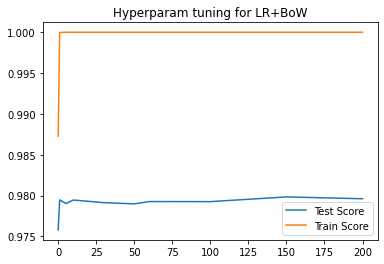

In [13]:
plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.legend(["Test Score", "Train Score"])
plt.title("Hyperparam tuning for LR+BoW")
plt.show()

In [14]:
LR_BOW = LogisticRegression(C=10)
LR_BOW.fit(X_train_bow, y_train)
preds = LR_BOW.predict(X_test_bow)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score, confusion_matrix

In [16]:
print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9791336883004748
Accuracy:  0.9771419563332545
ROC AUC Score:  0.9771852375784035


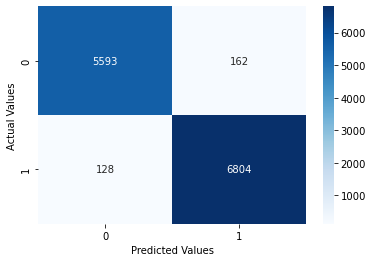

In [17]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [18]:
## Hyperparam Tuning with TFIDF

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[0.01,1,5,10,20,30,60,100,150,200]}
grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1',n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 1, 5, 10, 20, 30, 60, 100, 150, 200]},
             return_train_score=True, scoring='f1')

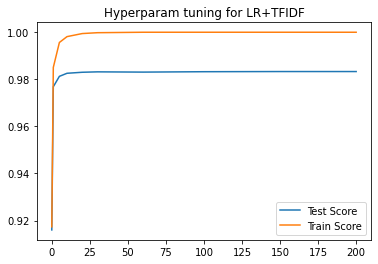

In [19]:
plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [20]:
LR_TFIDF = LogisticRegression(C=20)
LR_TFIDF.fit(X_train_tfidf, y_train)
preds = LR_TFIDF.predict(X_test_tfidf)

In [21]:
print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9823275862068965
Accuracy:  0.9806100733033815
ROC AUC Score:  0.980860968588972


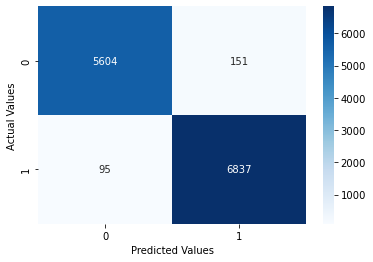

In [22]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Conclusion: We get a slightly better F1 Score when using the tf-idf features

<p> Using Max Features on BoW and tfidf and comparing scores

In [23]:
def return_best_score_max_fea(max_fea):
    cv = CountVectorizer(max_features=max_fea)
    cv.fit(X_train)
    X_train_bow = cv.transform(X_train)
    X_test_bow = cv.transform(X_test)

    tfidf = TfidfVectorizer(max_features=max_fea)
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    

    lr = LogisticRegression()
    params = {'C':[0.01,0.1,1,5,7,10,20]}
    grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1')
    grid.fit(X_train_bow, y_train)
    
    best_score_bow = grid.best_score_
    
    lr = LogisticRegression()
    params = {'C':[0.01,0.1,1,5,7,10,20]}
    grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1')
    grid.fit(X_train_tfidf, y_train)
    
    best_score_tfidf = grid.best_score_
    
    return best_score_bow, best_score_tfidf


In [24]:
from tqdm import tqdm

In [25]:
best_scores_bow_fea = []
best_scores_tfidf_fea = []
max_fea = [2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    vals = return_best_score_max_fea(i)
    best_scores_bow_fea.append(vals[0])
    best_scores_tfidf_fea.append(vals[1])                          

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [27:53<00:00, 88.09s/it]


In [26]:
for i in range(len(max_fea)):
    print("For max_features = ",max_fea[i],", BoW Score = ",best_scores_bow_fea[i]," and TF-IDF Score = ",best_scores_tfidf_fea[i])

For max_features =  2000 , BoW Score =  0.9776868088608042  and TF-IDF Score =  0.9794587874250039
For max_features =  5000 , BoW Score =  0.9803068376430504  and TF-IDF Score =  0.9819412170939895
For max_features =  6000 , BoW Score =  0.9802353965401162  and TF-IDF Score =  0.9820811398618092
For max_features =  7000 , BoW Score =  0.9801303698428505  and TF-IDF Score =  0.9822249360751943
For max_features =  8000 , BoW Score =  0.9805492022017891  and TF-IDF Score =  0.9823659390311906
For max_features =  8500 , BoW Score =  0.9804132985074581  and TF-IDF Score =  0.9823930540921559
For max_features =  9000 , BoW Score =  0.9803397063085237  and TF-IDF Score =  0.982397406667196
For max_features =  12000 , BoW Score =  0.9804139539251111  and TF-IDF Score =  0.982854694248763
For max_features =  14000 , BoW Score =  0.9804172418449463  and TF-IDF Score =  0.9828567953173055
For max_features =  14500 , BoW Score =  0.980350873206054  and TF-IDF Score =  0.9828235326298858
For max_fe

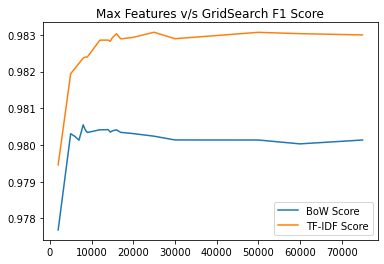

In [27]:
plt.plot(max_fea, best_scores_bow_fea)
plt.plot(max_fea, best_scores_tfidf_fea)
plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["BoW Score", "TF-IDF Score"])
plt.show()

<p>max_features = 25000 seems to be giving the best score, so we will try tfidf features with 25000 max features on our test data and compare it with our earlier model with no value of max_features specified.

In [28]:
tfidf = TfidfVectorizer(max_features=50000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
## Hyperparam Tuning with TFIDF + 50000 Max Features

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[1,5,10,20,50,100,200,250,300]}
grid = GridSearchCV(lr, params, cv=4, return_train_score=True, scoring='f1', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 5, 10, 20, 50, 100, 200, 250, 300]},
             return_train_score=True, scoring='f1')

In [30]:
print(grid.cv_results_['mean_train_score'])
print(grid.cv_results_['mean_test_score'])

[0.98487944 0.99554349 0.99816535 0.9994198  0.99994079 1.
 1.         1.         1.        ]
[0.97632285 0.98144703 0.98271241 0.98274928 0.98340996 0.98358882
 0.98361732 0.98354677 0.9836534 ]


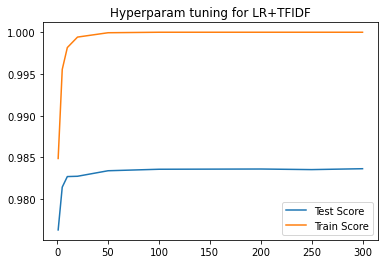

In [31]:
plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [33]:
LR_TFIDF = LogisticRegression(C=50)
LR_TFIDF.fit(X_train_tfidf, y_train)
preds = LR_TFIDF.predict(X_test_tfidf)

In [34]:
print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9823981607874128
Accuracy:  0.9806888941436116
ROC AUC Score:  0.9809324459710892


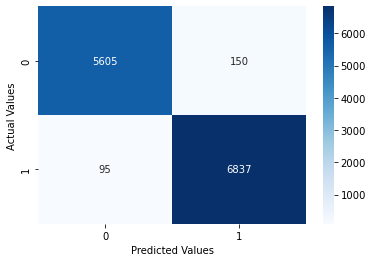

In [35]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### We were able to slightly increase our score on tfidf data using max_features = 17000

### Summary for non-lemmatized data

In [36]:
myTable = PrettyTable(["Model","Data type", "F1-Score"])
myTable.add_row(["Logistic Regression", "Bag of Words", "0.9791"])
myTable.add_row(["Logistic Regression", "TF-IDF", "0.9823"])
myTable.add_row(["Logistic Regression", "TF-IDF + Max Features = 50000", "0.9824"])

print(myTable)


+---------------------+-------------------------------+----------+
|        Model        |           Data type           | F1-Score |
+---------------------+-------------------------------+----------+
| Logistic Regression |          Bag of Words         |  0.9791  |
| Logistic Regression |             TF-IDF            |  0.9823  |
| Logistic Regression | TF-IDF + Max Features = 50000 |  0.9824  |
+---------------------+-------------------------------+----------+


#### 1.3 No Lemmatization, Stop-Word Removal 

In [37]:
def return_best_score_max_fea_stopwords(max_fea):
    cv = CountVectorizer(max_features=max_fea, stop_words='english')
    cv.fit(X_train)
    X_train_bow = cv.transform(X_train)
    X_test_bow = cv.transform(X_test)

    tfidf = TfidfVectorizer(max_features=max_fea, stop_words='english')
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)
    

    lr = LogisticRegression()
    params = {'C':[0.01,0.1,1,5,7,10,20]}
    grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1')
    grid.fit(X_train_bow, y_train)
    
    best_score_bow = grid.best_score_
    
    lr = LogisticRegression()
    params = {'C':[0.01,0.1,1,5,7,10,20]}
    grid = GridSearchCV(lr, params, cv=5, return_train_score=True, scoring='f1')
    grid.fit(X_train_tfidf, y_train)
    
    best_score_tfidf = grid.best_score_
    
    return best_score_bow, best_score_tfidf

In [38]:
best_scores_bow_fea = []
best_scores_tfidf_fea = []
max_fea = [2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    vals = return_best_score_max_fea_stopwords(i)
    best_scores_bow_fea.append(vals[0])
    best_scores_tfidf_fea.append(vals[1])  

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [21:32<00:00, 68.04s/it]


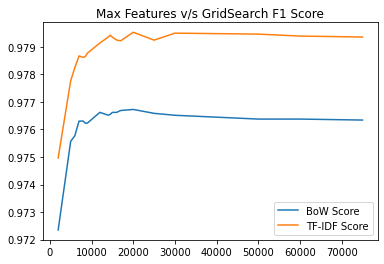

In [39]:
plt.plot(max_fea, best_scores_bow_fea)
plt.plot(max_fea, best_scores_tfidf_fea)
plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["BoW Score", "TF-IDF Score"])
plt.show()

In [40]:
best_scores_tfidf_fea

[0.974965773461804,
 0.9777690507779893,
 0.9782480755127961,
 0.9786712692551319,
 0.978620067692912,
 0.978648508942172,
 0.9787701032670301,
 0.9791410063418213,
 0.9793582262311629,
 0.979424793375002,
 0.979353789613539,
 0.9792499981468463,
 0.9792214280357541,
 0.9795325709876053,
 0.9792456570640722,
 0.9795000507385838,
 0.9794641750260572,
 0.9793936367161681,
 0.9793588595207494]

In [41]:
tfidf = TfidfVectorizer(max_features=50000, stop_words='english')
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [42]:
## Hyperparam Tuning with TFIDF + Stop Word Removal + 50000 Max Features

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[1,5,7,10,20,50,100,200,300]}
grid = GridSearchCV(lr, params, cv=4, return_train_score=True, scoring='f1', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 5, 7, 10, 20, 50, 100, 200, 300]},
             return_train_score=True, scoring='f1')

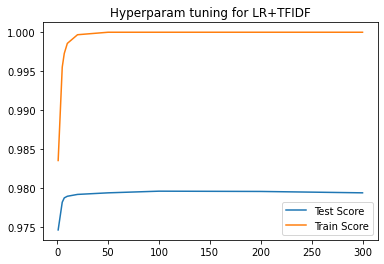

In [43]:
plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [44]:
LR_TFIDF = LogisticRegression(C=20)
LR_TFIDF.fit(X_train_tfidf, y_train)
preds = LR_TFIDF.predict(X_test_tfidf)

In [45]:
print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9793459552495697
Accuracy:  0.9772995980137148
ROC AUC Score:  0.9777166393168665


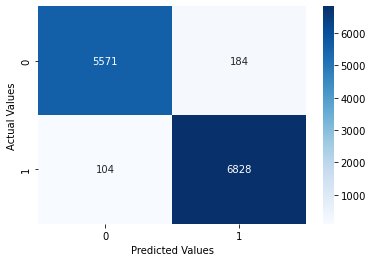

In [46]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### 1.4 Only Lemmatization, No Stop-Word Removal 

In [22]:
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

In [ ]:
def lemmatize_func(text):
    newText = ""
    for word in text.split():
        newWord = lemmatizer.lemmatize(word, pos ="v")
        if word == newWord:
            newWord = lemmatizer.lemmatize(word, pos ="n")
        if word == newWord:
            newWord = lemmatizer.lemmatize(word, pos ="a")
        if word == newWord:
            newWord = lemmatizer.lemmatize(word, pos ="r")
        newText+= newWord + " "
    newText = newText.strip()
    return newText
    

In [ ]:
lemmatize_func(df_final['processed_text'][0])

In [ ]:
df_final['processed_text'] = [lemmatize_func(x) for x in df_final['processed_text']]
    

In [ ]:
df_final.to_csv("lemmatized.csv")

In [47]:
df_final = pd.read_csv("lemmatized.csv")


In [48]:
X = df_final['processed_text']
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [49]:
best_scores_bow_fea = []
best_scores_tfidf_fea = []
max_fea = [2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    vals = return_best_score_max_fea(i)
    best_scores_bow_fea.append(vals[0])
    best_scores_tfidf_fea.append(vals[1])                          

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [26:35<00:00, 83.97s/it]


In [50]:
for i in range(len(max_fea)):
    print("For max_features = ",max_fea[i],", BoW Score = ",best_scores_bow_fea[i]," and TF-IDF Score = ",best_scores_tfidf_fea[i])

For max_features =  2000 , BoW Score =  0.9768733951933412  and TF-IDF Score =  0.9790719012945852
For max_features =  5000 , BoW Score =  0.9789951895698064  and TF-IDF Score =  0.9813357590461951
For max_features =  6000 , BoW Score =  0.9793159891615847  and TF-IDF Score =  0.9815855486669959
For max_features =  7000 , BoW Score =  0.9793525304954184  and TF-IDF Score =  0.9813622719615468
For max_features =  8000 , BoW Score =  0.9794577318792669  and TF-IDF Score =  0.9811893652162995
For max_features =  8500 , BoW Score =  0.9795323419652646  and TF-IDF Score =  0.981369472720169
For max_features =  9000 , BoW Score =  0.9794224368826849  and TF-IDF Score =  0.9813321675315623
For max_features =  12000 , BoW Score =  0.9794914929028709  and TF-IDF Score =  0.9816829298362245
For max_features =  14000 , BoW Score =  0.9793180916413983  and TF-IDF Score =  0.9817176886813636
For max_features =  14500 , BoW Score =  0.9793889995497341  and TF-IDF Score =  0.9817536462262559
For max_

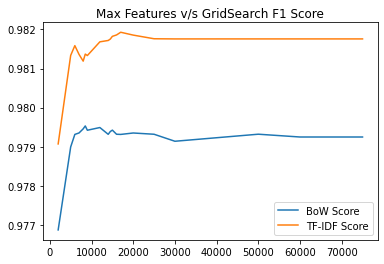

In [51]:
plt.plot(max_fea, best_scores_bow_fea)
plt.plot(max_fea, best_scores_tfidf_fea)
plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["BoW Score", "TF-IDF Score"])
plt.show()

In [52]:
tfidf = TfidfVectorizer(max_features=17000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

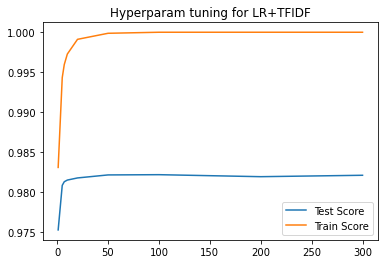

In [53]:
## Hyperparam Tuning with TFIDF + Lemmatization + 17000 Max Features

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[1,5,7,10,20,50,100,200,300]}
grid = GridSearchCV(lr, params, cv=4, return_train_score=True, scoring='f1', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [54]:
print(grid.cv_results_['mean_train_score'])
print(grid.cv_results_['mean_test_score'])

[0.98306767 0.99431679 0.99595671 0.99726747 0.99911208 0.99986974
 1.         1.         1.        ]
[0.97524215 0.98082307 0.98127653 0.98148492 0.98175213 0.98212948
 0.98216025 0.98190948 0.98208599]


In [55]:
LR_TFIDF = LogisticRegression(C=50)
LR_TFIDF.fit(X_train_tfidf, y_train)
preds = LR_TFIDF.predict(X_test_tfidf)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9815333764460732
Accuracy:  0.9797430440608497
ROC AUC Score:  0.9799605658967064


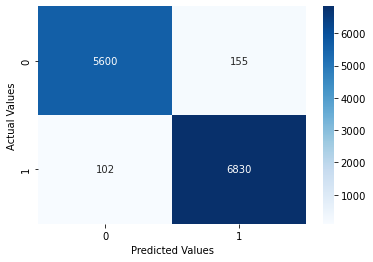

In [56]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### 1.5 Lemmatization and Stop-Word Removal 

In [57]:
best_scores_bow_fea = []
best_scores_tfidf_fea = []
max_fea = [2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    vals = return_best_score_max_fea_stopwords(i)
    best_scores_bow_fea.append(vals[0])
    best_scores_tfidf_fea.append(vals[1]) 

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [20:47<00:00, 65.67s/it]


In [58]:
for i in range(len(max_fea)):
    print("For max_features = ",max_fea[i],", BoW Score = ",best_scores_bow_fea[i]," and TF-IDF Score = ",best_scores_tfidf_fea[i])

For max_features =  2000 , BoW Score =  0.9710021336411737  and TF-IDF Score =  0.9741824649942469
For max_features =  5000 , BoW Score =  0.9730368709140574  and TF-IDF Score =  0.9762997948753002
For max_features =  6000 , BoW Score =  0.973016101953567  and TF-IDF Score =  0.9762348342456546
For max_features =  7000 , BoW Score =  0.9732228190719013  and TF-IDF Score =  0.9763426064506792
For max_features =  8000 , BoW Score =  0.9731196498047296  and TF-IDF Score =  0.9768891963723334
For max_features =  8500 , BoW Score =  0.9732226774813135  and TF-IDF Score =  0.9771029075978961
For max_features =  9000 , BoW Score =  0.973188262438469  and TF-IDF Score =  0.9768857452143962
For max_features =  12000 , BoW Score =  0.9731882747307312  and TF-IDF Score =  0.9771040426494713
For max_features =  14000 , BoW Score =  0.9732245986799077  and TF-IDF Score =  0.9770350481230976
For max_features =  14500 , BoW Score =  0.9732588365120083  and TF-IDF Score =  0.977210804335078
For max_fe

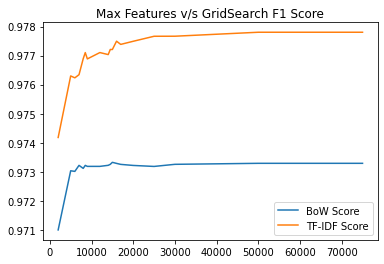

In [59]:
plt.plot(max_fea, best_scores_bow_fea)
plt.plot(max_fea, best_scores_tfidf_fea)
plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["BoW Score", "TF-IDF Score"])
plt.show()

In [60]:
tfidf = TfidfVectorizer(max_features=30000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

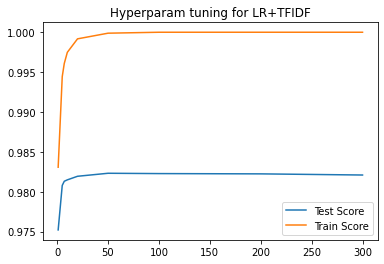

In [61]:
## Hyperparam Tuning with TFIDF + Lemmatization + Stop Word Removal + 17000 Max Features

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
params = {'C':[1,5,7,10,20,50,100,200,300]}
grid = GridSearchCV(lr, params, cv=4, return_train_score=True, scoring='f1', n_jobs=-1)
grid.fit(X_train_tfidf, y_train)

plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [62]:
print(grid.cv_results_['mean_train_score'])
print(grid.cv_results_['mean_test_score'])

[0.98306687 0.99443469 0.99608652 0.99748028 0.99917127 0.99988158
 1.         1.         1.        ]
[0.97520262 0.98078366 0.98130539 0.98148251 0.98193134 0.98230924
 0.98226918 0.98223387 0.98208951]


In [63]:
LR_TFIDF = LogisticRegression(C=50)
LR_TFIDF.fit(X_train_tfidf, y_train)
preds = LR_TFIDF.predict(X_test_tfidf)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9816091954022987
Accuracy:  0.9798218649010798
ROC AUC Score:  0.9800645389840835


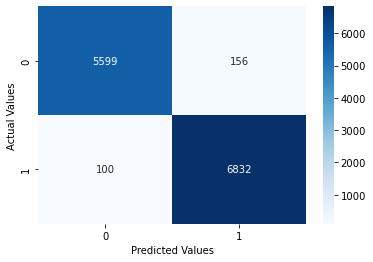

In [64]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [65]:
myTable = PrettyTable(["Model","Data type", "F1-Score"])
myTable.add_row(["Logistic Regression", "TF-IDF + Stop Word Removal + Max Features = 50000", "0.9793"])
myTable.add_row(["Logistic Regression", "TF-IDF + Lemmatization + Max Features = 17000", "0.9815"])
myTable.add_row(["Logistic Regression", "TF-IDF + Stop Word Removal + Lemmatization + Max Features = 30000", "0.9816"])

print(myTable)


+---------------------+-------------------------------------------------------------------+----------+
|        Model        |                             Data type                             | F1-Score |
+---------------------+-------------------------------------------------------------------+----------+
| Logistic Regression |         TF-IDF + Stop Word Removal + Max Features = 50000         |  0.9793  |
| Logistic Regression |           TF-IDF + Lemmatization + Max Features = 17000           |  0.9815  |
| Logistic Regression | TF-IDF + Stop Word Removal + Lemmatization + Max Features = 30000 |  0.9816  |
+---------------------+-------------------------------------------------------------------+----------+


#### From our base model performance on variour types of data, we can observe that:

    - TF-IDF performs better than BoW in all circumstances.
    - It is important to optimize the number of max features as this can give us a minor boost in F1-Score.
    
#### Taking these points into account, we will take our best performing features and use various models on the data to get a better score than the base logistic regression model.

## 2. Using Various Models on Best Features

<p>Our best performing feature in the previous section was tf-idf with best max_features value, so we will use that data as features for our models.</p>

In [4]:
df_final = loadFinalData()

X = df_final['processed_text']
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

#### 2.1 Naive Bayes Classifier

In [67]:
def return_best_score_max_fea_nb(max_fea):
    tfidf = TfidfVectorizer(max_features=max_fea)
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    
    nb = MultinomialNB(class_prior = [0.5,0.5])
    parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
    gridsearch = GridSearchCV(nb, parameters, cv = 5, scoring='f1', return_train_score=True, n_jobs=-1)
    gridsearch.fit(X_train_tfidf, y_train)
    
    best_score_tfidf = gridsearch.best_score_
    
    return best_score_tfidf


In [68]:
best_scores_tfidf_fea = []
max_fea = [500,1000,2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    best_scores_tfidf_fea.append(return_best_score_max_fea_nb(i))                          

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:11<00:00, 12.00s/it]


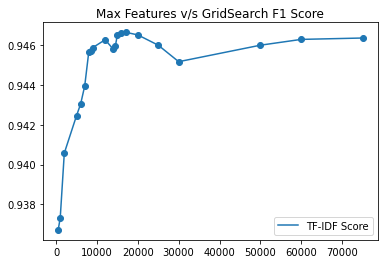

In [69]:
plt.plot(max_fea, best_scores_tfidf_fea)
plt.scatter(max_fea, best_scores_tfidf_fea)

plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["TF-IDF Score"])

plt.show()

In [70]:
for i in range(len(max_fea)):
    print("For max_features = ",max_fea[i]," and TF-IDF Score = ",best_scores_tfidf_fea[i])

For max_features =  500  and TF-IDF Score =  0.9367259925116072
For max_features =  1000  and TF-IDF Score =  0.9373141406052847
For max_features =  2000  and TF-IDF Score =  0.9405754145283053
For max_features =  5000  and TF-IDF Score =  0.942456729753484
For max_features =  6000  and TF-IDF Score =  0.9430389932407103
For max_features =  7000  and TF-IDF Score =  0.9439447998914791
For max_features =  8000  and TF-IDF Score =  0.9456627411101011
For max_features =  8500  and TF-IDF Score =  0.9457164418788702
For max_features =  9000  and TF-IDF Score =  0.9458684608077641
For max_features =  12000  and TF-IDF Score =  0.9462589619859617
For max_features =  14000  and TF-IDF Score =  0.9457810794634753
For max_features =  14500  and TF-IDF Score =  0.9459457308506106
For max_features =  15000  and TF-IDF Score =  0.9465138090733456
For max_features =  16000  and TF-IDF Score =  0.9465785119402778
For max_features =  17000  and TF-IDF Score =  0.9466343651973839
For max_features =  2

In [71]:
tfidf = TfidfVectorizer(max_features=17000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [72]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(class_prior = [0.5,0.5])

parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

gridsearch = GridSearchCV(nb, parameters, cv = 5, scoring='f1', return_train_score=True, n_jobs=-1)
gridsearch.fit(X_train_tfidf, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(class_prior=[0.5, 0.5]), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='f1')

In [73]:
gridsearch.best_estimator_

MultinomialNB(alpha=1e-05, class_prior=[0.5, 0.5])

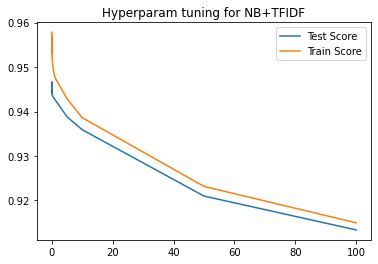

In [74]:
plt.plot(parameters['alpha'], gridsearch.cv_results_['mean_test_score'])
plt.plot(parameters['alpha'], gridsearch.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for NB+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [75]:
NB_TFIDF = MultinomialNB(class_prior = [0.5,0.5], alpha=0.00001)
NB_TFIDF.fit(X_train_tfidf, y_train)
preds = NB_TFIDF.predict(X_test_tfidf)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9433333333333334
Accuracy:  0.9383621029400173
ROC AUC Score:  0.9375178469142367


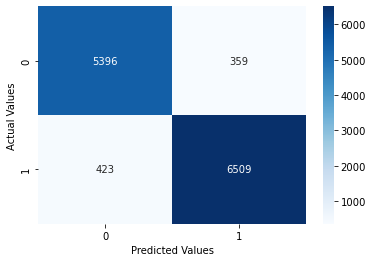

In [76]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### 2.2 SVM Classifier

In [77]:
def return_best_score_max_fea_svm(max_fea):
    tfidf = TfidfVectorizer(max_features=max_fea)
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    
    svm = LinearSVC()
    params = {'C':[0.01,0.1,1,5,7]}
    grid = GridSearchCV(svm, params, cv=3, return_train_score=True, scoring='f1')
    grid.fit(X_train_tfidf, y_train)
    
    best_score_tfidf = grid.best_score_
    
    return best_score_tfidf


In [78]:
best_scores_tfidf_fea = []
max_fea = [500,1000,2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    best_scores_tfidf_fea.append(return_best_score_max_fea_svm(i))                          

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [04:28<00:00, 12.76s/it]


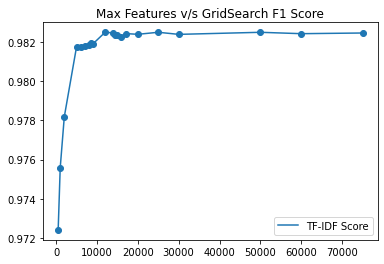

In [79]:
plt.plot(max_fea, best_scores_tfidf_fea)
plt.scatter(max_fea, best_scores_tfidf_fea)

plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["TF-IDF Score"])

plt.show()

In [80]:
for i in range(len(max_fea)):
    print("For max_features = ",max_fea[i]," and TF-IDF Score = ",best_scores_tfidf_fea[i])

For max_features =  500  and TF-IDF Score =  0.9724028048935698
For max_features =  1000  and TF-IDF Score =  0.9755756704548425
For max_features =  2000  and TF-IDF Score =  0.978184815371869
For max_features =  5000  and TF-IDF Score =  0.9817639329234474
For max_features =  6000  and TF-IDF Score =  0.9817285181145903
For max_features =  7000  and TF-IDF Score =  0.9818009945985716
For max_features =  8000  and TF-IDF Score =  0.9818733578297335
For max_features =  8500  and TF-IDF Score =  0.9819800427600218
For max_features =  9000  and TF-IDF Score =  0.9819096212843892
For max_features =  12000  and TF-IDF Score =  0.9825059316943254
For max_features =  14000  and TF-IDF Score =  0.9824703801601409
For max_features =  14500  and TF-IDF Score =  0.9823648109938157
For max_features =  15000  and TF-IDF Score =  0.982363307290476
For max_features =  16000  and TF-IDF Score =  0.9822593973069038
For max_features =  17000  and TF-IDF Score =  0.9824377999706252
For max_features =  20

In [81]:
tfidf = TfidfVectorizer(max_features=12000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [82]:
svm = LinearSVC()
params = {'C':[0.001,0.01,0.1,1,5,7,10,20,50,100]}
grid = GridSearchCV(svm, params, cv=5, return_train_score=True, scoring='f1', verbose = 1)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 7, 10, 20, 50, 100]},
             return_train_score=True, scoring='f1', verbose=1)

In [83]:
grid.best_estimator_

LinearSVC(C=1)

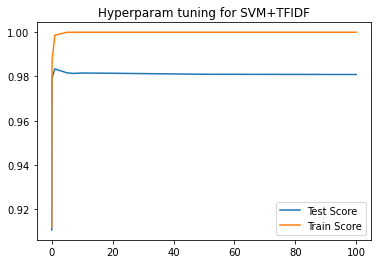

In [84]:
plt.plot(params['C'], grid.cv_results_['mean_test_score'])
plt.plot(params['C'], grid.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for SVM+TFIDF")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [85]:
SVM_TFIDF = LinearSVC(C=1)
SVM_TFIDF.fit(X_train_tfidf, y_train)
preds = SVM_TFIDF.predict(X_test_tfidf)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9816065526656129
Accuracy:  0.9798218649010798
ROC AUC Score:  0.9800482891259252


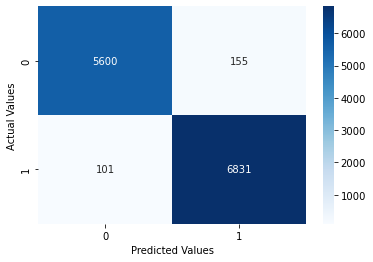

In [86]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

#### 2.3 DecisionTree Classifier

In [87]:
def return_best_score_max_fea_dt(max_fea):
    tfidf = TfidfVectorizer(max_features=max_fea)
    tfidf.fit(X_train)
    X_train_tfidf = tfidf.transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    
    dt = DecisionTreeClassifier()
    params = {'max_depth':[10,50,100,200]}
    grid = GridSearchCV(dt, params, cv=3, return_train_score=True, scoring='f1')
    grid.fit(X_train_tfidf, y_train)
    
    best_score_tfidf = grid.best_score_
    
    return best_score_tfidf


In [88]:
best_scores_tfidf_fea = []
max_fea = [500,1000,2000,5000,6000,7000,8000,8500,9000,12000,14000,14500,15000,16000,17000,20000,25000,30000,50000,60000,75000]

for i in tqdm(max_fea):
    best_scores_tfidf_fea.append(return_best_score_max_fea_dt(i))                          

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [41:44<00:00, 119.26s/it]


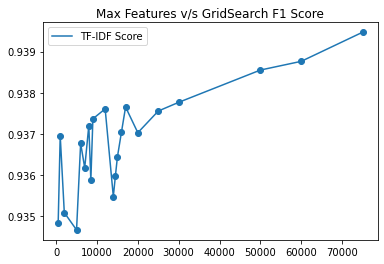

In [89]:
plt.plot(max_fea, best_scores_tfidf_fea)
plt.scatter(max_fea, best_scores_tfidf_fea)

plt.title("Max Features v/s GridSearch F1 Score")
plt.legend(["TF-IDF Score"])

plt.show()

In [5]:
tfidf = TfidfVectorizer(max_features=60000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [13]:
dt = DecisionTreeClassifier()
params={"splitter":["best","random"],
            "max_depth" : [10,20,500,400],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
grid = GridSearchCV(dt, params, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(X_train_tfidf, y_train)

Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 500, 400],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             scoring='f1', verbose=2)

In [14]:
grid.best_estimator_

DecisionTreeClassifier(max_depth=400, max_leaf_nodes=90, min_samples_leaf=3)

In [94]:
grid.cv_results_['params']

[{'max_depth': 5, 'min_samples_split': 2},
 {'max_depth': 5, 'min_samples_split': 3},
 {'max_depth': 5, 'min_samples_split': 5},
 {'max_depth': 10, 'min_samples_split': 2},
 {'max_depth': 10, 'min_samples_split': 3},
 {'max_depth': 10, 'min_samples_split': 5},
 {'max_depth': 50, 'min_samples_split': 2},
 {'max_depth': 50, 'min_samples_split': 3},
 {'max_depth': 50, 'min_samples_split': 5},
 {'max_depth': 100, 'min_samples_split': 2},
 {'max_depth': 100, 'min_samples_split': 3},
 {'max_depth': 100, 'min_samples_split': 5}]

In [16]:
grid.cv_results_['mean_test_score']

array([0.74370868, 0.727499  , 0.747614  , ..., 0.93624487, 0.93748063,
       0.93515932])

In [17]:
DT_TFIDF = DecisionTreeClassifier(max_depth=400, max_leaf_nodes=90, min_samples_leaf=3)
DT_TFIDF.fit(X_train_tfidf, y_train)
preds = DT_TFIDF.predict(X_test_tfidf)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.9447826398338467
Accuracy:  0.9392291321825491
ROC AUC Score:  0.9393625964786778


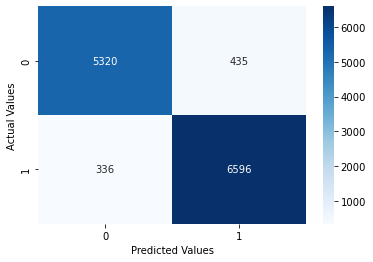

In [18]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Conclusion

Linear Models are performing better than non-linear models, with Logistic Regression model being the best out of all.

In [20]:
myTable = PrettyTable(["Model","Data type", "F1-Score"])
myTable.add_row(["Naive Bayes", "TF-IDF + Max Features = 17000", "0.9433"])
myTable.add_row(["SVM", "TF-IDF Max Features = 12000", "0.9816"])
myTable.add_row(["Decision Tree", "TF-IDF Max Features = 60000", "0.9448"])

print(myTable)


+---------------+-------------------------------+----------+
|     Model     |           Data type           | F1-Score |
+---------------+-------------------------------+----------+
|  Naive Bayes  | TF-IDF + Max Features = 17000 |  0.9433  |
|      SVM      |  TF-IDF Max Features = 12000  |  0.9816  |
| Decision Tree |  TF-IDF Max Features = 60000  |  0.9448  |
+---------------+-------------------------------+----------+


### Using TF-IDF Weighted GloVe Values

In [6]:
df_final_lemmatized = pd.read_csv("lemmatized.csv")
df_final = loadFinalData()

X = df_final['processed_text']
y = df_final['label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
X_l = df_final_lemmatized['processed_text']
y_l = df_final_lemmatized['label']
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_l, y_l, test_size=0.33, random_state=42, stratify=y)

In [7]:
#On Non Lemmatized Data
tfidf = TfidfVectorizer(max_features=50000)
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#On Lemmatized Data
tfidf_lem = TfidfVectorizer(max_features=17000)
tfidf_lem.fit(X_train)
X_train_tfidf_lem = tfidf_lem.transform(X_train)
X_test_tfidf_lem = tfidf_lem.transform(X_test)

In [8]:
#idf dictionary for non lemmatized data

dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())

#idf dictionary for lemmatized data
dictionary_lem = dict(zip(tfidf_lem.get_feature_names(), list(tfidf_lem.idf_)))
tfidf_words_lem = set(tfidf_lem.get_feature_names())

In [9]:
f =  open("glove.6B.50d.txt", encoding="utf8") 
vector_glove = {}
for i in f:
    x = i.split(' ')
    word = x[0]
    values = np.asarray(x[1:]).astype('float32')
    vector_glove[word] = values

In [10]:
vector_glove['for']

array([ 0.15272 ,  0.36181 , -0.22168 ,  0.066051,  0.13029 ,  0.37075 ,
       -0.75874 , -0.44722 ,  0.22563 ,  0.10208 ,  0.054225,  0.13494 ,
       -0.43052 , -0.2134  ,  0.56139 , -0.21445 ,  0.077974,  0.10137 ,
       -0.51306 , -0.40295 ,  0.40639 ,  0.23309 ,  0.20696 , -0.12668 ,
       -0.50634 , -1.7131  ,  0.077183, -0.39138 , -0.10594 , -0.23743 ,
        3.9552  ,  0.66596 , -0.61841 , -0.3268  ,  0.37021 ,  0.25764 ,
        0.38977 ,  0.27121 ,  0.043024, -0.34322 ,  0.020339,  0.2142  ,
        0.044097,  0.14003 , -0.20079 ,  0.074794, -0.36076 ,  0.43382 ,
       -0.084617,  0.1214  ], dtype=float32)

In [92]:
#Applying tfidf-weighted GloVe vectorization on train data - Non Lemmatized
tfidf_w2v_vectors_tr = []; 
for article in tqdm(X_train):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words):
            vec = vector_glove[word]
            tf_idf = dictionary[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_tr.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 25758/25758 [03:25<00:00, 125.45it/s]


In [114]:
len(tfidf_w2v_vectors_tr)

25758

In [14]:
#Applying tfidf-weighted GloVe vectorization on train data - Lemmatized
tfidf_w2v_vectors_tr_l = []; 
for article in tqdm(X_train_l):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words_lem):
            vec = vector_glove[word]
            tf_idf = dictionary_lem[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_tr_l.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 25758/25758 [03:11<00:00, 134.82it/s]


In [93]:
#Applying tfidf-weighted GloVe vectorization on test data - Non Lemmatized
tfidf_w2v_vectors_te = []; 
for article in tqdm(X_test):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words):
            vec = vector_glove[word]
            tf_idf = dictionary[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_te.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 12687/12687 [01:43<00:00, 122.08it/s]


In [15]:
#Applying tfidf-weighted GloVe vectorization on test data - Lemmatized
tfidf_w2v_vectors_te_l = []; 
for article in tqdm(X_test_l):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words_lem):
            vec = vector_glove[word]
            tf_idf = dictionary_lem[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_te_l.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 12687/12687 [01:33<00:00, 136.20it/s]


In [16]:
np.savetxt("w2v_test_nonlem.csv", 
           tfidf_w2v_vectors_te,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("w2v_train_nonlem.csv", 
           tfidf_w2v_vectors_tr,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("w2v_test_lem.csv", 
           tfidf_w2v_vectors_te_l,
           delimiter =", ", 
           fmt ='% s')
np.savetxt("w2v_train_lem.csv", 
           tfidf_w2v_vectors_tr_l,
           delimiter =", ", 
           fmt ='% s')

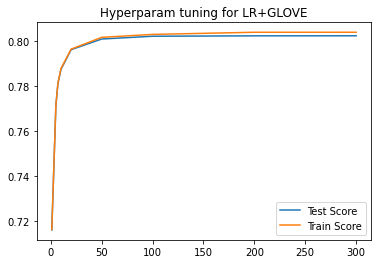

In [32]:
#Hyperparameter tuning for LR with tf-idf weighted GloVe
lr = LogisticRegression()
params = {'C':[1,5,7,10,20,50,100,200,300]}
grid_lr = GridSearchCV(lr, params, cv=4, return_train_score=True, scoring='f1', n_jobs=-1)
grid_lr.fit(tfidf_w2v_vectors_tr, y_train)

plt.plot(params['C'], grid_lr.cv_results_['mean_test_score'])
plt.plot(params['C'], grid_lr.cv_results_['mean_train_score'])
plt.title("Hyperparam tuning for LR+GLOVE")
plt.legend(["Test Score", "Train Score"])
plt.show()

In [33]:
grid_lr.best_score_

0.8023849258774932

In [18]:
#Hyperparameter tuning for DT with tf-idf weighted GloVe
dt = DecisionTreeClassifier()
params={"splitter":["best","random"],
            "max_depth" : [10,20,500,400],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }
grid = GridSearchCV(dt, params, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(tfidf_w2v_vectors_tr, y_train)


Fitting 3 folds for each of 3200 candidates, totalling 9600 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 500, 400],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 20, 30, 40, 50, 60, 70,
                                            80, 90],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'splitter': ['best', 'random']},
             scoring='f1', verbose=2)

In [19]:
grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 90,
 'min_samples_leaf': 7,
 'splitter': 'best'}

In [21]:
grid.best_score_

0.8764321738405426

In [22]:
#Predicting with DT for tf-idf weighted GloVe

DT_GLOVE = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=90, min_samples_leaf=7, max_features=None, splitter= 'best')
DT_GLOVE.fit(tfidf_w2v_vectors_tr, y_train)
preds = DT_GLOVE.predict(tfidf_w2v_vectors_te)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.8804652754019843
Accuracy:  0.862299992117916
ROC AUC Score:  0.8689564552965202


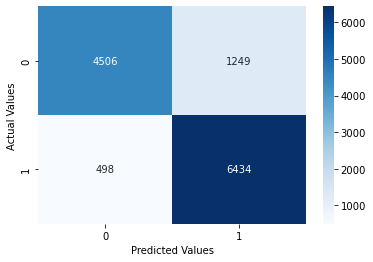

In [23]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [24]:
#Hyperparameter tuning for DT with tf-idf weighted GloVe - Lemmatized

dt = DecisionTreeClassifier()
params={"splitter":["best","random"],
            "max_depth" : [8,10,20,50,100],
           "min_samples_leaf":[4,5,6,7,8],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[70,80,90,100,120] }
grid = GridSearchCV(dt, params, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(tfidf_w2v_vectors_tr_l, y_train)


Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [8, 10, 20, 50, 100],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'max_leaf_nodes': [70, 80, 90, 100, 120],
                         'min_samples_leaf': [4, 5, 6, 7, 8],
                         'splitter': ['best', 'random']},
             scoring='f1', verbose=2)

In [26]:
grid.best_params_

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 4,
 'splitter': 'best'}

In [25]:
grid.best_score_


0.8813362443733922

In [28]:
#Predicting with DT for tf-idf weighted GloVe - Lemmatized

DT_GLOVE_LEM = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=100, min_samples_leaf=4, max_features=None, splitter= 'best')
DT_GLOVE_LEM.fit(tfidf_w2v_vectors_tr_l, y_train)
preds = DT_GLOVE_LEM.predict(tfidf_w2v_vectors_te_l)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.8796383753879369
Accuracy:  0.8593836210294001
ROC AUC Score:  0.8700701325527441


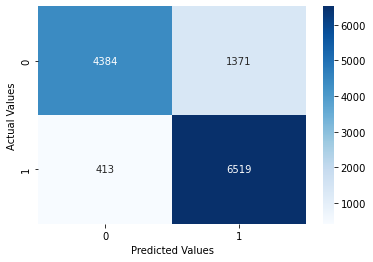

In [29]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [30]:
from sklearn.ensemble import RandomForestClassifier


In [31]:
#Hyperparameter tuning for RF with tf-idf weighted GloVe

rf = RandomForestClassifier()
params={"n_estimators":[50,100,150,200],
            "max_depth" : [None,20,50,100,200],
           "max_features":["auto","log2","sqrt",None] }
grid = GridSearchCV(rf, params, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid.fit(tfidf_w2v_vectors_tr, y_train)


Fitting 3 folds for each of 80 candidates, totalling 240 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 20, 50, 100, 200],
                         'max_features': ['auto', 'log2', 'sqrt', None],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='f1', verbose=2)

In [34]:
grid.best_params_

{'max_depth': 200, 'max_features': 'auto', 'n_estimators': 200}

In [35]:
grid.best_score_

0.9105128496869951

In [38]:
#Predicting with RF for tf-idf weighted GloVe

RF_GLOVE = RandomForestClassifier(max_depth= 200, max_features= 'auto', n_estimators= 200)
RF_GLOVE.fit(tfidf_w2v_vectors_tr, y_train)
preds = RF_GLOVE.predict(tfidf_w2v_vectors_te)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

F1-Score:  0.912287903667214
Accuracy:  0.8989516828249389
ROC AUC Score:  0.9073394198774853


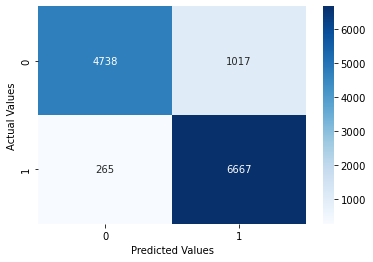

In [39]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

In [40]:
import lightgbm as lgb


In [44]:
#Hyperparameter tuning for GBDT with tf-idf weighted GloVe

parameters = {
     "n_estimators"     : [50,100,200,300,400],
     "max_depth"        : [None, 1,2,3,10],
    "max_features":["auto"]
}

clf = lgb.LGBMClassifier()

lgb.LGBMClassifier

grid = GridSearchCV(clf, parameters, n_jobs=-1, scoring="f1", cv=3, verbose=2, return_train_score=True)

grid.fit(tfidf_w2v_vectors_tr, y_train)


Fitting 3 folds for each of 25 candidates, totalling 75 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 2, 3, 10],
                         'max_features': ['auto'],
                         'n_estimators': [50, 100, 200, 300, 400]},
             return_train_score=True, scoring='f1', verbose=2)

In [45]:
grid.best_params_

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 400}

In [46]:
grid.best_score_

0.905889214134212

In [94]:
#Predicting with GBDT for tf-idf weighted GloVe

lgb_GLOVE = lgb.LGBMClassifier(max_depth= 10, max_features= 'auto', n_estimators= 400)
lgb_GLOVE.fit(tfidf_w2v_vectors_tr, y_train)
preds = lgb_GLOVE.predict(tfidf_w2v_vectors_te)

print("F1-Score: ",f1_score(preds,y_test))
print("Accuracy: ",accuracy_score(preds,y_test))
print("ROC AUC Score: ",roc_auc_score(preds,y_test))

[LightGBM] [Warning] Unknown parameter: max_features
F1-Score:  0.9083090581217921
Accuracy:  0.8957988492157326
ROC AUC Score:  0.900433741779759


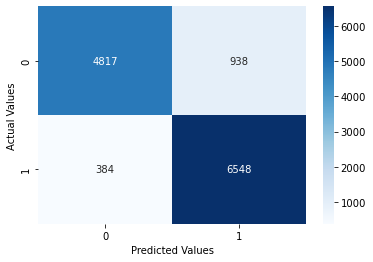

In [95]:
sns.heatmap(confusion_matrix(y_test,preds), annot=True, cmap='Blues', fmt="d")
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()

### Conclusion

Using TF-IDF weighted gloVe vectors does not give a better result than TF-IDF.

In [51]:
myTable = PrettyTable(["Model","Data type", "F1-Score"])
myTable.add_row(["Logistic Regression", "TF-IDF weighted GloVe", "0.8024"])
myTable.add_row(["Decision Tree", "TF-IDF weighted GloVe", "0.8805"])
myTable.add_row(["Decision Tree", "TF-IDF weighted GloVe + Lemmatization", "0.8796"])
myTable.add_row(["Random Forest", "TF-IDF weighted GloVe", "0.9123"])
myTable.add_row(["Gradient Boosted DT", "TF-IDF weighted GloVe", "0.9059"])

print(myTable)


+---------------------+---------------------------------------+----------+
|        Model        |               Data type               | F1-Score |
+---------------------+---------------------------------------+----------+
| Logistic Regression |         TF-IDF weighted GloVe         |  0.8024  |
|    Decision Tree    |         TF-IDF weighted GloVe         |  0.8805  |
|    Decision Tree    | TF-IDF weighted GloVe + Lemmatization |  0.8796  |
|    Random Forest    |         TF-IDF weighted GloVe         |  0.9123  |
| Gradient Boosted DT |         TF-IDF weighted GloVe         |  0.9059  |
+---------------------+---------------------------------------+----------+


### Testing the Top Models with Real Life News Articles - 5 Fake and 5 Real

Just to ensure if our model will perform well in real world and how trustworthy our scores are, we will run a few different models on 10 news articles collected from the internet - 5 real and 5 fake 

In [71]:
df_onion = pd.read_csv('Latest Onion Articles.csv')

In [74]:
df_onion

,text
0,"HIGHLAND PARK, IL—In the hours following a vio..."
1,"LOCK HAVEN, PA—Ashley Daniels is as close as y..."
2,If you think all corporate CEOs are heartless ...
3,"PALM BEACH, FL—In a series of posts shared to ..."
4,WASHINGTON—Outraged by reports of the family-f...
5,Last week calls from Texas began flooding into...
6,London (CNN Business)If you're an American vis...
7,The Eiffel Tower is riddled with rust and in n...
8,(CNN)Two police officers were shot during a Ju...
9,New York (CNN Business)Subway is launching a n...


In [76]:
onion_processed = []
for i in tqdm(range(10)):
    text = preprocess_text(df_onion.text[i])
    onion_processed.append(text)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.73it/s]


In [77]:
df_onion['processed_text'] = onion_processed

#### Predictions using LR + TF-IDF

In [78]:
tfidf = TfidfVectorizer(max_features=50000)
tfidf.fit(df_final['processed_text'].values)
X_train_tfidf = tfidf.transform(df_final['processed_text'].values)
onion_tfidf = tfidf.transform(df_onion['processed_text'].values)

In [80]:
LR_TFIDF = LogisticRegression(C=50)
LR_TFIDF.fit(X_train_tfidf, df_final['label'].values)
preds = LR_TFIDF.predict(onion_tfidf)

In [81]:
preds

array([0, 0, 0, 0, 0, 1, 1, 1, 0, 1], dtype=int64)

#### Predictions using DT + TF-IDF Weighted GloVe

In [82]:
#Applying tfidf-weighted GloVe vectorization on WHOLE train data

dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_words = set(tfidf.get_feature_names())


tfidf_w2v_vectors_tr = []; 
for article in tqdm(df_final['processed_text'].values):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words):
            vec = vector_glove[word]
            tf_idf = dictionary[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_tr.append(vector)
    

100%|███████████████████████████████████████████████████████████████████████████| 38445/38445 [05:15<00:00, 121.96it/s]


In [83]:
#Applying tfidf-weighted GloVe vectorization on 10 New Articles

tfidf_w2v_vectors_te = []; 
for article in tqdm(df_onion['processed_text'].values):
    vector = np.zeros(50) 
    tf_idf_weight = 0; 
    for word in article.split(): 
        if (word in vector_glove) and (word in tfidf_words):
            vec = vector_glove[word]
            tf_idf = dictionary[word]*(article.count(word)/len(article.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
    tfidf_w2v_vectors_te.append(vector)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 103.32it/s]


In [84]:
DT_GLOVE = DecisionTreeClassifier(max_depth=10, max_leaf_nodes=90, min_samples_leaf=7, max_features=None, splitter= 'best')
DT_GLOVE.fit(tfidf_w2v_vectors_tr, df_final['label'].values)
preds = DT_GLOVE.predict(tfidf_w2v_vectors_te)

In [85]:
preds

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

#### Predictions using RF + TF-IDF Weighted GloVe

In [87]:
RF_GLOVE = RandomForestClassifier(max_depth= 200, max_features= 'auto', n_estimators= 200)
RF_GLOVE.fit(tfidf_w2v_vectors_tr, df_final['label'].values)
preds = RF_GLOVE.predict(tfidf_w2v_vectors_te)

In [88]:
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

#### Predictions using GBDT + TF-IDF Weighted GloVe

In [90]:
lgb_GLOVE = lgb.LGBMClassifier(max_depth= 10, max_features= 'auto', n_estimators= 400)
lgb_GLOVE.fit(tfidf_w2v_vectors_tr, df_final['label'].values)
preds = lgb_GLOVE.predict(tfidf_w2v_vectors_te)

In [91]:
preds

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

lr_tfidf = [0, 0, 0, 0, 0, 1, 1, 1, 0, 1]
dt_glove = [1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
rf_glove = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
gbdt_glove = [1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
actual = [0,0,0,0,0,1,1,1,1,1]

df_temp = pd.DataFrame({'lr_tfidf':f1_score(lr_tfidf,actual),'dt_glove':f1_score(dt_glove,actual),'rf_glove':f1_score(rf_glove,actual),'gbdt_glove':f1_score(gbdt_glove,actual)}, index=[0])

df_temp



,lr_tfidf,dt_glove,rf_glove,gbdt_glove
0,0.888889,0.769231,0.666667,0.714286


Text(0, 0.5, 'F1-Score')

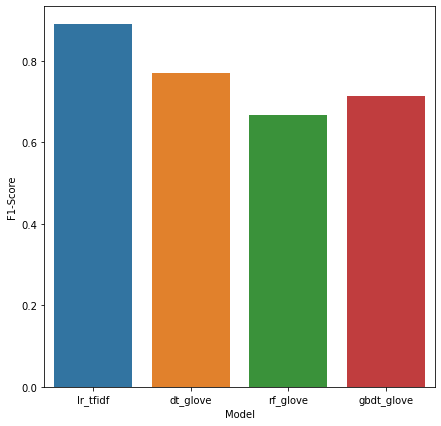

In [20]:
plt.figure(figsize=(7,7))
sns.barplot(x=df_temp.columns, y=df_temp.values[0])
plt.xlabel('Model')
plt.ylabel('F1-Score')

